# **Interactive Plotting and Monte Carlo Simulations of CPPI**

## Constant Proportion Portfolio Insurance (CPPI)

Constant Proportion Portfolio Insurance (CPPI) is a dynamic portfolio allocation strategy that aims to protect a minimum level of wealth (the **floor**) while allowing participation in the upside of a risky asset. The strategy adjusts exposure based on the **cushion**, which represents how much the portfolio value exceeds the floor.

### 1. Key Components

- **Floor (F):**  
  The minimum acceptable portfolio value that the strategy seeks to protect.

- **Cushion (C):**  
  $$C_t = V_t - F$$  
  where \(V_t\) is the total portfolio value at time \(t\).

- **Multiplier (m):**  
  A constant that determines how aggressively the cushion is allocated to the risky asset.

### 2. Allocation Rule

The exposure to the risky asset at time \(t\) is:

$$
E_t = m \times C_t
$$

or explicitly,

$$
E_t = m\,(V_t - F)
$$

**Rules (render-safe):**

- **Cap exposure at portfolio value:**  
  If the computed exposure is greater than the portfolio value, i.e.
  $$
  E_t > V_t,
  $$
  then set
  $$
  E_t \leftarrow V_t.
  $$

- **Move to risk-free if cushion non-positive:**  
  If the cushion is zero or negative, i.e.
  $$
  C_t \le 0,
  $$
  then set
  $$
  E_t \leftarrow 0
  $$
  and allocate the entire portfolio to the risk-free asset.

### 3. Portfolio Update Equation

Given the risky asset return displayed as the variable below and the risk-free rate:

- risky asset return: $$r_{t+1}^{\mathrm{risky}}$$  
- risk-free rate: $$r_f$$

the portfolio update is

$$
V_{t+1}
= E_t\big(1 + r_{t+1}^{\mathrm{risky}}\big)
+ \big(V_t - E_t\big)(1 + r_f)
$$

This update rule is applied iteratively across all time steps to simulate the CPPI portfolio path.

### 4. Intuition

- When the portfolio grows → cushion increases → exposure rises → higher upside participation.  
- When markets fall → cushion decreases → exposure reduces → floor protection activates.  
- CPPI behaves like a synthetic call option, providing convexity to the payoff.

### 5. Strengths

- Simple rule-based implementation.  
- Offers downside protection while preserving upside potential.  
- Allows controlled leverage via the multiplier.

### 6. Limitations

- **Gap Risk:** Large sudden drops can breach the floor before the system can rebalance.  
- Frequent rebalancing can lead to transaction costs.  
- Strategy is sensitive to the chosen multiplier.

### 7. CPPI in Monte Carlo Simulation

Monte Carlo simulation helps evaluate:
- Probability of hitting or breaching the floor.  
- Distribution of terminal portfolio values.  
- Impact of volatility, drift, and multiplier size.  
- Performance under stressed or extreme scenarios.

The simulation involves generating risky asset paths (e.g., via GBM) and applying the CPPI rule at each step to observe how the portfolio evolves.


In [1]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import pandas as pd
import Risk_Kit as rk
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## **GBM Simulations**

In [2]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0=100
    prices = rk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=100, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0,s_0, marker='o',color='darkred', alpha=0.2)


In [3]:
gbm_controls = widgets.interactive(show_gbm, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=1, value=1), 
                                   mu=(0., +.2,.01),
                                   sigma=(0, .3, .01)
)

In [4]:
display(gbm_controls)

interactive(children=(IntSlider(value=1, description='n_scenarios', max=1000, min=1), FloatSlider(value=0.1, d…

# Interactive CPPI Monte Carlo Testing

In [5]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = rk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = rk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    y_max=wealth.values.max()*y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(12, 6))
    ax.axhline(y=start, ls=":", color="black")
    ax.axhline(y=start*floor, ls="--", color="red")
    ax.set_ylim(top=y_max)

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .30, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

# Adding a Histogram and Reporting Floor Violations

In [6]:

def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = rk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = rk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

# Adding Terminal Wealth Statistics

In [7]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, steps_per_year=12, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = rk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = rk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]

    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12,
                                                          description="Rebals/Year"),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

# **CPPI ON INDUSTRY RETURNS**

In [8]:
# Load the industry returns and the total market index we previously created
ind_return = rk.get_ind_returns()
tmi_return = rk.get_total_market_index_returns()

Loading industry returns and the total market index of Kenneth-30 French Industry data

In [9]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

We start with start invested value at $1000 and floor to be at 80% of start value from 2000 onwards

In [10]:
# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)


In [11]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()


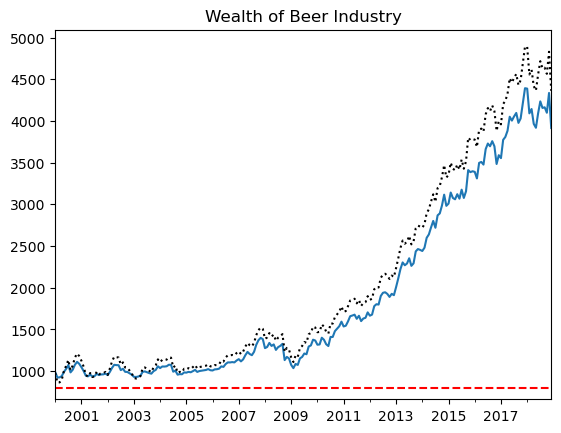

In [12]:
ind = "Beer"
ax = account_history[ind].plot()
risky_wealth[ind].plot(title='Wealth of Beer Industry',style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

Observe the floor at red dotted line and plot for the Beer industry returns

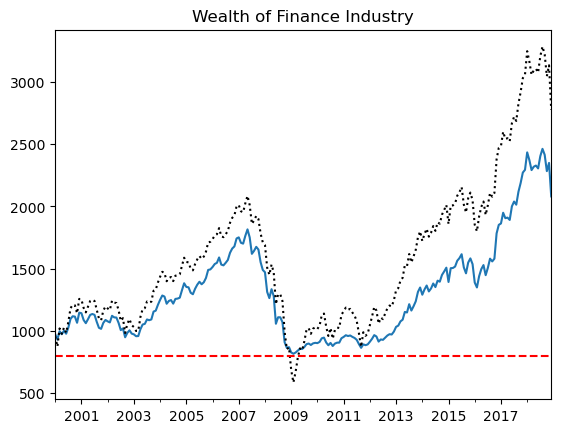

In [13]:
ind = "Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(title='Wealth of Finance Industry',style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

Observe the floor at red dotted line and plot for the Finance industry returns. Also observe the efficiency of CPPI where the valuation could have been below the cushion level, we immediately were able to secure from downside risk

<Axes: title={'center': 'Changes in Cushion for Finance Industry'}, ylabel='Percentage in Cushion'>

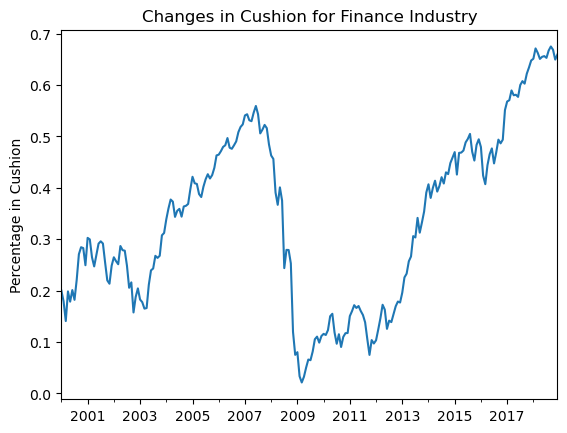

In [14]:
cushion_history["Fin"].plot(title='Changes in Cushion for Finance Industry',ylabel='Percentage in Cushion')

Observing the above plot, we can verify the drop in 2009. 

<Axes: title={'center': 'Returns of Steel, Finance, Beer Industry without CPPI'}, ylabel='Returns in Raw Percentage'>

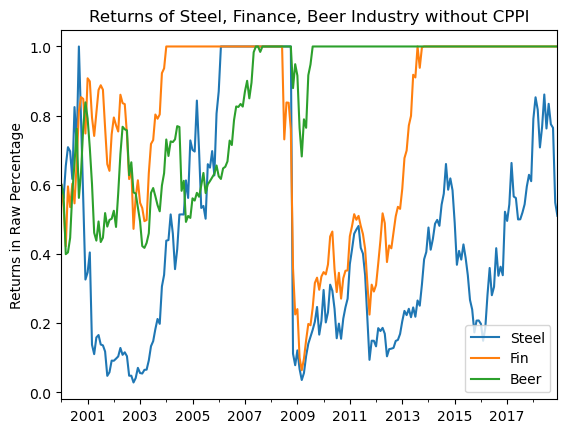

In [15]:
risky_w_history.plot(title='Returns of Steel, Finance, Beer Industry without CPPI',ylabel='Returns in Raw Percentage')

Here we observe the risky asset if considered without CPPI of steel, finance and beer industry

<Axes: title={'center': 'Wealth Index of Various Industries from 2007 onwards'}, ylabel='Wealth'>

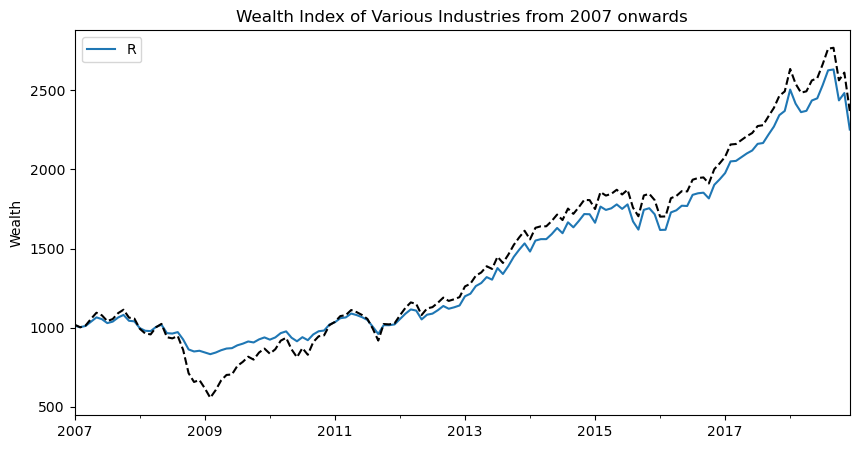

In [16]:
btr = rk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(title='Wealth Index of Various Industries from 2007 onwards',legend=True, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False,ylabel='Wealth')

In this we observe that without CPPI, we would have lost our wealth 

<Axes: title={'center': 'Wealth Index with CPPI(dotted) and without CPPI(solid) from 2007 and in Steel, Finance and Beer'}, ylabel='Wealth'>

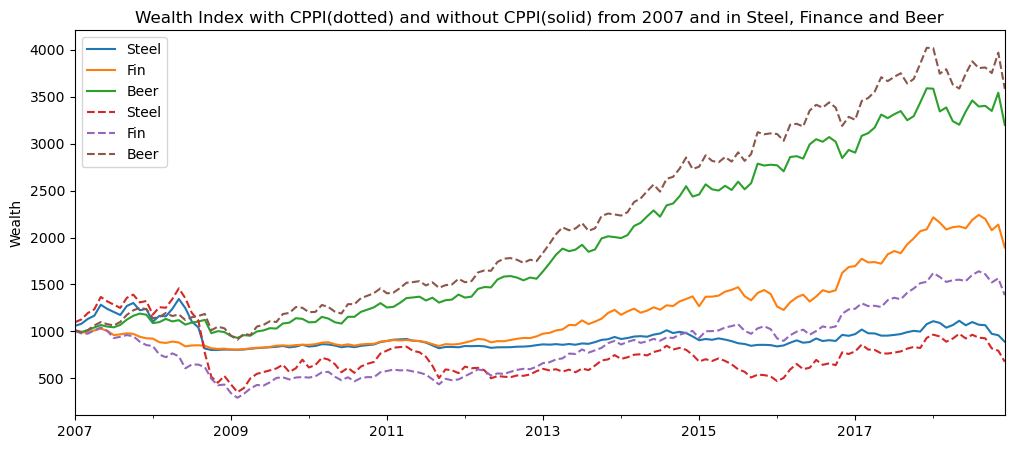

In [17]:
btr = rk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(title='Wealth Index with CPPI(dotted) and without CPPI(solid) from 2007 and in Steel, Finance and Beer',figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--",ylabel='Wealth')

Observe the dotted line(with CPPI) and the solid line(without CPPI) show the wealth difference 

In [18]:
rk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280


We Compute the metrics with CPPI

In [19]:
rk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


We compute the metric without CPPI

Note that the returns, VaR, CVar, Sharpe Ratio and Max Drawdowns are improved with CPPI strategy in comparison to without implementation of CPPI